In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib

# for BERT tokenization
# from transformers import BertTokenizer, TFAutoModel

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8034452389470292390
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1254985121345388714
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [6]:
# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [8]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


<Axes: ylabel='Commodity'>

19720

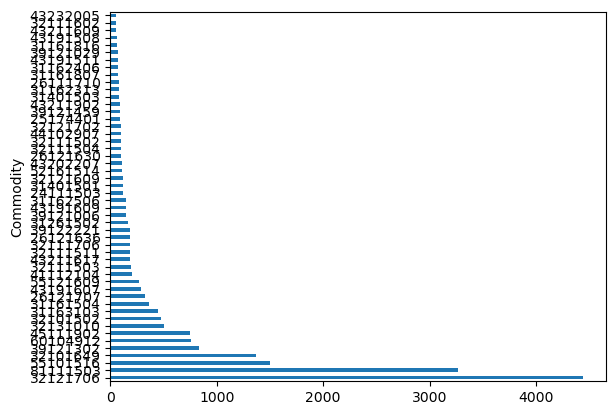

In [9]:
# get dataframe of the top 50 Commodity CODES
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [10]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])


In [11]:
# load the GloVe word embeddings
embeddings_index = {}

# where do you find the glove.6B.100d.txt file?
# 1. download from https://nlp.stanford.edu/projects/glove/
# 2. unzip the file
# 3. move the file to the same folder as this notebook
# 4. run the code below


with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# create a tokenizer object
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df7['Product_Description'])

# convert the text data to sequence of integers
sequences = tokenizer.texts_to_sequences(df7['Product_Description'])

# pad the sequences to have a consistent length
max_length = max([len(s) for s in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# create the vector representations of the text data using the embedding matrix
df_vectors_glove = np.zeros((len(df7['Product_Description']), max_length, 100))
for i, seq in enumerate(padded_sequences):
    for j, word_idx in enumerate(seq):
        df_vectors_glove[i,j,:] = embedding_matrix[word_idx]


In [12]:
# convert the vector representations back to text data
df7['tokens_glove'] = tokenizer.sequences_to_texts(sequences)
df7

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,tokens_glove
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,0 set up sheet for ccx600 d
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,1000 004 res 270 ohm cf 1 8 w 5
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,1000 005 res 200 ohm cf 1 8 w 5
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,1000 06 res 56k cf 1 8 w 5
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,1000 075 res 100k cf 1 8 w 5
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,36k 5 1 16w 0402 lf
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,res 1 16w 510k ohms 5 0402
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,c0g 50v 0201 lf
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,01f side 16n smd


In [13]:
# split X and y_encoded into training test and validation sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(df_vectors_glove, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)

In [14]:
# convert the true labels from one-hot encoded format to class labels
y_test_labels_enc = label_encoder.inverse_transform(y_test_enc)


In [15]:
# default model callback settings

def create_checkpoint(model_name):
    return ModelCheckpoint(
        filepath=model_name,
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        monitor='val_loss',
        verbose=1
    )

early_stopping = EarlyStopping(patience=10, restore_best_weights=True,monitor='val_loss')

In [19]:
k.clear_session()
model_glove = Sequential()
model_glove.add(Dense(64, input_shape=(max_length, 100), activation='relu'))
model_glove.add(Dropout(0.5))
model_glove.add(Flatten())
model_glove.add(Dense(50, activation='softmax'))
model_glove.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29, 64)            6464      
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                92850     
                                                                 
Total params: 99,314
Trainable params: 99,314
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_glove = model_glove.fit(X_train_enc, y_train_enc, validation_data=(X_val_enc, y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_nn_glove_prodmod_enc.h5'),early_stopping], verbose=1)

Epoch 1/100
226/250 [==========================>...] - ETA: 0s - loss: 2.0209 - accuracy: 0.5088
Epoch 1: val_loss improved from inf to 1.03883, saving model to best_model_nn_glove_prodmod_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 1.9438 - accuracy: 0.5271 - val_loss: 1.0388 - val_accuracy: 0.7454
Epoch 2/100
236/250 [===========================>..] - ETA: 0s - loss: 0.9031 - accuracy: 0.7679
Epoch 2: val_loss improved from 1.03883 to 0.64491, saving model to best_model_nn_glove_prodmod_enc.h5
250/250 [==============================] - 0s 2ms/step - loss: 0.8957 - accuracy: 0.7702 - val_loss: 0.6449 - val_accuracy: 0.8299
Epoch 3/100
226/250 [==========================>...] - ETA: 0s - loss: 0.6479 - accuracy: 0.8316
Epoch 3: val_loss improved from 0.64491 to 0.52250, saving model to best_model_nn_glove_prodmod_enc.h5
250/250 [==============================] - 0s 2ms/step - loss: 0.6462 - accuracy: 0.8326 - val_loss: 0.5225 - val_accuracy: 0.8620
Epoch 4/100

In [21]:
pred_nn = model_glove.predict(X_test_enc)
pred_nn_decoded = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))
print_validation_report(y_test_labels_enc, pred_nn_decoded)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      0.67      0.80         6
    26111710       1.00      0.60      0.75         5
    26121630       1.00      0.50      0.67        10
    26121636       1.00      0.93      0.96        14
    26121707       0.80      1.00      0.89        28
    31161504       0.98      1.00      0.99        53
    31161807       0.88      0.58      0.70        12
    31161816       0.67      0.67      0.67         9
    31162313       0.67      0.67      0.67         6
    31162406       0.90      0.90      0.90        10
    31162506       0.67      0.86      0.75        14
    31163103       0.94      1.00      0.97        47
    31261502       1.00      1.00      1.00        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.75      0.86         8
    32

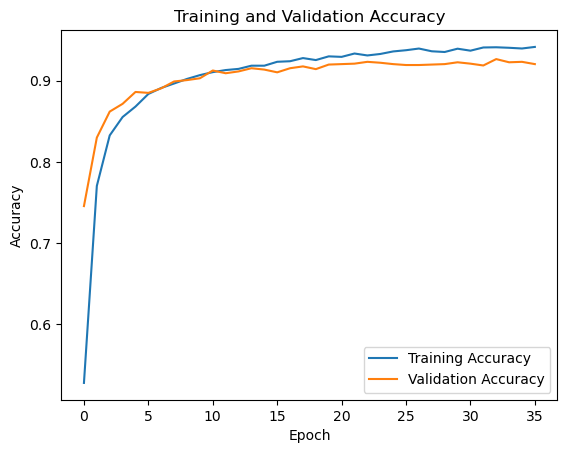

In [22]:
# plot the training and validation accuracy
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

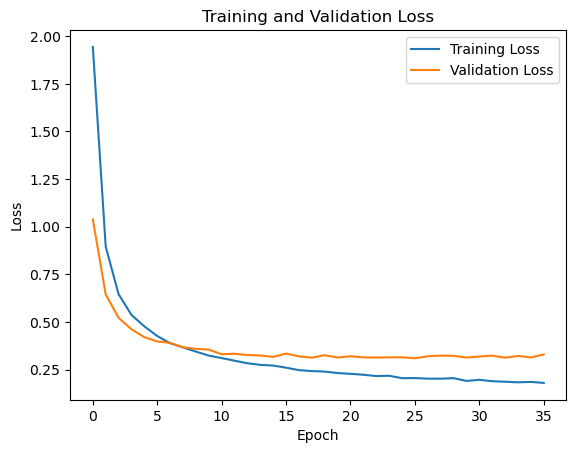

In [23]:
# plot the training and validation loss
plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [26]:
# create a logistic regression object
logreg = LogisticRegression()

# fit the model on the training data
logreg.fit(X_train_enc.reshape(X_train_enc.shape[0], -1), y_train_enc)


LogisticRegression()

In [27]:
pred_lr = logreg.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))
pred_lr_decoded = label_encoder.inverse_transform(pred_lr)
print_validation_report(y_test_labels_enc, pred_lr_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       1.00      1.00      1.00        11
    25174401       1.00      0.67      0.80         6
    26111710       1.00      0.80      0.89         5
    26121630       0.57      0.40      0.47        10
    26121636       1.00      0.93      0.96        14
    26121707       0.82      1.00      0.90        28
    31161504       1.00      1.00      1.00        53
    31161807       1.00      0.50      0.67        12
    31161816       1.00      0.56      0.71         9
    31162313       0.62      0.83      0.71         6
    31162406       1.00      0.80      0.89        10
    31162506       0.80      0.86      0.83        14
    31163103       0.90      0.98      0.94        47
    31261502       1.00      1.00      1.00        14
    31401501       0.93      0.87      0.90        15
    31401503       0.83      0.62      0.71         8
    32101502       0.85      0.94      0.90        50
    3

In [28]:
# create a MLPClassifier object
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

# fit the model on the training data
mlp.fit(X_train_enc.reshape(X_train_enc.shape[0], -1), y_train_enc)


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

In [29]:
pred_mlp = mlp.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))
pred_mlp_decoded = label_encoder.inverse_transform(pred_mlp)
print_validation_report(y_test_labels_enc, pred_mlp_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.91      0.91      0.91        11
    25174401       1.00      0.50      0.67         6
    26111710       1.00      0.80      0.89         5
    26121630       0.43      0.30      0.35        10
    26121636       1.00      0.93      0.96        14
    26121707       0.88      1.00      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.42      0.59        12
    31161816       1.00      0.44      0.62         9
    31162313       0.80      0.67      0.73         6
    31162406       0.89      0.80      0.84        10
    31162506       0.73      0.79      0.76        14
    31163103       0.85      0.98      0.91        47
    31261502       1.00      1.00      1.00        14
    31401501       0.93      0.93      0.93        15
    31401503       1.00      0.62      0.77         8
    32101502       0.84      0.94      0.89        50
    3

In [30]:
# Train the RFC model
rfc = RandomForestClassifier()
rfc.fit(X_train_enc.reshape(X_train_enc.shape[0], -1), y_train_enc)


RandomForestClassifier()

In [31]:
# make predictions on the test data
pred_mlp = rfc.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))
pred_mlp_decoded = label_encoder.inverse_transform(pred_mlp)
print_validation_report(y_test_labels_enc, pred_mlp_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       1.00      1.00      1.00        11
    25174401       1.00      0.83      0.91         6
    26111710       1.00      1.00      1.00         5
    26121630       0.38      0.30      0.33        10
    26121636       1.00      0.93      0.96        14
    26121707       0.97      1.00      0.98        28
    31161504       0.98      1.00      0.99        53
    31161807       0.89      0.67      0.76        12
    31161816       1.00      0.78      0.88         9
    31162313       0.60      0.50      0.55         6
    31162406       1.00      0.70      0.82        10
    31162506       0.86      0.86      0.86        14
    31163103       0.96      0.98      0.97        47
    31261502       1.00      1.00      1.00        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.75      0.86         8
    32101502       0.87      0.96      0.91        50
    3

In [ ]:
# # create the MultinomialNB object
# nb = MultinomialNB()

# # fit the model to the training data
# nb.fit(X_train_enc.reshape(X_train_enc.shape[0], -1), y_train_enc)


In [ ]:
# # predict the test data
# pred_nb = nb.predict(X_test_count_enc)

# # print the classification report and accuracy score
# print_validation_report(y_test_decoded, label_encoder.inverse_transform(pred_nb))

In [32]:
# create the SVM object
svm = SVC()

# fit the model to the training data
svm.fit(X_train_enc.reshape(X_train_enc.shape[0], -1), y_train_enc)


SVC()

In [33]:
# # predict the test data
# pred_svm = svm.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))

# # print the classification report and accuracy score
# print_validation_report(y_test_labels_enc, label_encoder.inverse_transform(pred_svm))



pred_svm = svm.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))
pred_svm_decoded = label_encoder.inverse_transform(pred_svm)
print_validation_report(y_test_labels_enc, pred_svm_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       1.00      0.82      0.90        11
    25174401       1.00      0.50      0.67         6
    26111710       1.00      0.60      0.75         5
    26121630       0.67      0.40      0.50        10
    26121636       1.00      0.93      0.96        14
    26121707       0.93      1.00      0.97        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.50      0.67        12
    31161816       1.00      0.22      0.36         9
    31162313       0.62      0.83      0.71         6
    31162406       1.00      0.90      0.95        10
    31162506       0.62      0.57      0.59        14
    31163103       0.88      0.96      0.92        47
    31261502       1.00      1.00      1.00        14
    31401501       0.93      0.87      0.90        15
    31401503       1.00      0.50      0.67         8
    32101502       0.86      1.00      0.93        50
    3

In [ ]:
# # create the XGBClassifier object
# xgb = XGBClassifier()

# # fit the model to the training data
# xgb.fit(X_train_glove_enc.reshape(X_train_enc.shape[0], -1), y_train_enc)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [34]:
# create the XGBClassifier object
xgb = XGBClassifier(objective='multi:softmax', num_class=50)


In [37]:
eval_set = [(X_val_enc.reshape(X_val_enc.shape[0], -1), y_val_enc)]

# fit the model to the training data
xgb.fit(X_train_enc.reshape(X_train_enc.shape[0], -1), y_train_enc, eval_set=eval_set, 
        early_stopping_rounds=5, verbose=True)


[0]	validation_0-mlogloss:0.91630
[1]	validation_0-mlogloss:0.70118
[2]	validation_0-mlogloss:0.59722
[3]	validation_0-mlogloss:0.53181
[4]	validation_0-mlogloss:0.48291
[5]	validation_0-mlogloss:0.44518
[6]	validation_0-mlogloss:0.41831
[7]	validation_0-mlogloss:0.39639
[8]	validation_0-mlogloss:0.37714
[9]	validation_0-mlogloss:0.36257
[10]	validation_0-mlogloss:0.35164
[11]	validation_0-mlogloss:0.34245
[12]	validation_0-mlogloss:0.33475
[13]	validation_0-mlogloss:0.32665
[14]	validation_0-mlogloss:0.32052
[15]	validation_0-mlogloss:0.31456
[16]	validation_0-mlogloss:0.31088
[17]	validation_0-mlogloss:0.30773
[18]	validation_0-mlogloss:0.30426
[19]	validation_0-mlogloss:0.30155
[20]	validation_0-mlogloss:0.29926
[21]	validation_0-mlogloss:0.29700
[22]	validation_0-mlogloss:0.29587
[23]	validation_0-mlogloss:0.29381
[24]	validation_0-mlogloss:0.29254
[25]	validation_0-mlogloss:0.29207
[26]	validation_0-mlogloss:0.29118
[27]	validation_0-mlogloss:0.28988
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=50,
              num_parallel_tree=None, ...)

In [38]:
# # predict the test data
# pred_xgb = xgb.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))

# # print the classification report and accuracy score
# print_validation_report(y_test_decoded, label_encoder.inverse_transform(pred_xgb))

pred_xgb = xgb.predict(X_test_enc.reshape(X_test_enc.shape[0], -1))
pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
print_validation_report(y_test_labels_enc, pred_xgb_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       1.00      1.00      1.00        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       0.71      0.50      0.59        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      1.00      0.95        28
    31161504       1.00      1.00      1.00        53
    31161807       0.89      0.67      0.76        12
    31161816       1.00      0.78      0.88         9
    31162313       0.83      0.83      0.83         6
    31162406       1.00      0.90      0.95        10
    31162506       0.93      0.93      0.93        14
    31163103       0.96      0.94      0.95        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.86      0.75      0.80         8
    32101502       0.89      0.98      0.93        50
    3